In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
DATA = Path().cwd().parent / 'common_data'
PLOTS = Path().cwd() / 'plots'

HIST_YEARS = np.array(list(range(2000, 2021)))
PROJ_YEARS = np.array(list(range(2020, 2101, 5)))

In [3]:
# Font size of plots
plt.rcParams['font.size'] = 18

## Sources
How much energy will buildings consume in 2100? = how_much \
Supplementary to 'How much energy...' = supp (tables are SI#)

## Import Data

In [4]:
# From shared data
data = pd.read_excel(DATA / 'gdp_pop.xlsx',
                     sheet_name = 'data',
                     usecols = ['year', 'variable', 'unit', 'value'])
data.set_index(['variable', 'year'], inplace = True)
data = data[['value', 'unit']]

# Canada land area in sq. km (from Encyclopedia of World Geography vol 1, McColl)
can_area = 9984670

# GDP from world bank, iiasa
gdp_hist = data.loc['gdp_hist'].copy()
gdp_proj = data.loc['gdp_proj'].copy()

# Population from world bank, iiasa
pop_hist = data.loc['pop_hist'].copy()
pop_proj = data.loc['pop_proj'].copy()

# Income from world bank, calculated
income_hist = data.loc['income_hist'].copy()
income_proj = data.loc['income_proj'].copy()

# Density calculated
density_hist = pop_hist.copy()
density_hist['value'] = density_hist['value']*1e6/can_area
density_proj = pop_proj.copy()
density_proj['value'] = density_proj['value']*1e6/can_area

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

# Floor Space Demand

In [4]:
# Timestep function from how_much pp. 516
f_1 = lambda f_0, I_1, I_0, beta, D_1, D_0 : f_0*((I_1/I_0)**beta)*((D_1/D_0)**-0.03)

In [5]:
# Income elasticity starts at 0.42 (table SI4), ends at 0.7*0.42 = 0.294 (table SI5)
income_elasticities = pd.Series(np.linspace(0.42, 0.294, num = len(PROJ_YEARS)), 
                                index = PROJ_YEARS)

In [6]:
floor_demands = pd.DataFrame({'year': PROJ_YEARS,
                              'value': np.zeros(len(PROJ_YEARS)),
                              'unit': 'm^2/cap'})

floor_demands.set_index('year', inplace = True)

# Base year floor space demand (parameters from SI4)
alpha = 0.61
beta = 0.42
gamma = -0.03

# Base year formula from how_much pp. 516
floor_2020 = pd.Series({'value': alpha*(income_hist.loc[2020].value**beta)*density_hist.loc[2020].value**gamma, 'unit': 'm^2'},
                       name = 2020)
floor_demands.loc[2020] = floor_2020

In [7]:
# Calculate floorspace demands
for year in PROJ_YEARS[1:]:
    floor_demands.loc[year] = pd.Series({'value': f_1(floor_demands.loc[year-5].value, income_proj.loc[year].value, income_proj.loc[year-5].value, income_elasticities.loc[year], density_proj.loc[year].value, density_proj.loc[year-5].value),
                                         'unit': 'm^2'},
                                          name = year)

In [8]:
# "For levels of income per cap above 20,000 com to res area ratio levels off close to 35%" (how_much pp. 517)
res_floor_demands = floor_demands
com_floor_demands = res_floor_demands.copy()
com_floor_demands['value'] = com_floor_demands['value']*0.35

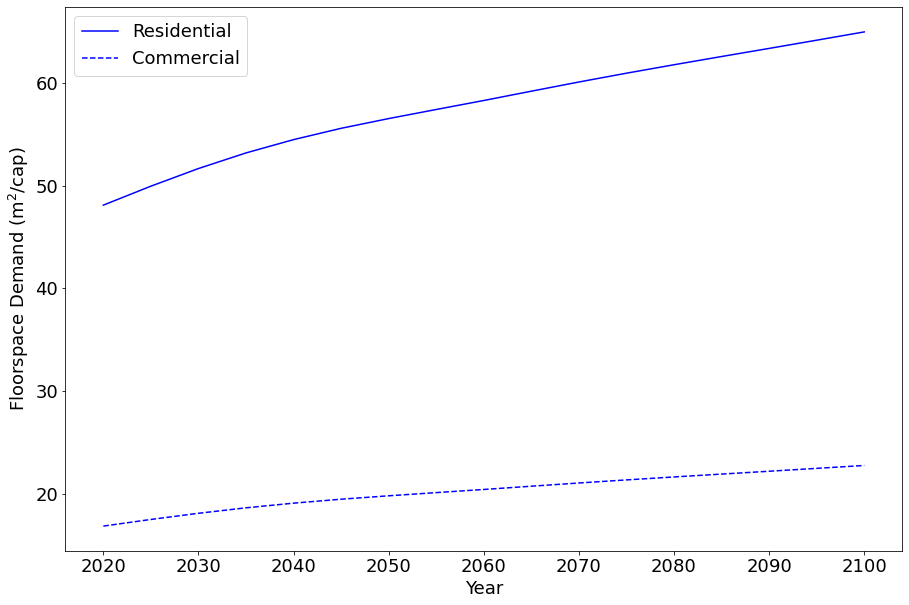

In [144]:
# Plotting data
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(PROJ_YEARS,
        res_floor_demands['value'],
        label = 'Residential',
        c = 'blue')
ax.plot(PROJ_YEARS,
        com_floor_demands['value'],
        label = 'Commercial',
        c = 'blue',
        ls = '--')
ax.legend()
ax.set(xlabel = 'Year',
       ylabel = 'Floorspace Demand (m$^2$/cap)');

In [156]:
fig.savefig(PLOTS / 'floorspace_demand.png')

## Space heating/cooling demand
Could try using the same projections as GCAM for better comparability

In [11]:
# HDD and CDD estimates copied roughly from fig. 2 of how_much (pp. 520)
hdd_projection = pd.Series(np.linspace(1200, 725, num = len(PROJ_YEARS)),
                           index = PROJ_YEARS)
cdd_projection = pd.Series(np.linspace(1250, 1800, num = len(PROJ_YEARS)),
                           index = PROJ_YEARS)

In [14]:
# Calculating insulation values
u_values = pd.Series(np.zeros(len(PROJ_YEARS)),
                     index = PROJ_YEARS)

# Tables SI4 and SI5
gamma = pd.Series(np.linspace(1, 0.7, num = len(PROJ_YEARS)),
                  index = PROJ_YEARS)

# Function found in supp pp. 5, parameters found in SI4
u_func = lambda y, hdd, cdd: y*(0.45 + np.exp(1.4 + (-5e-4)*(hdd+cdd)))

for year in PROJ_YEARS:
    u_values[year] = u_func(gamma[year], hdd_projection[year], cdd_projection[year])

In [35]:
# Formula from how_much pp. 517, parameters from SI4
SH = lambda floorspace, u, hdd: floorspace*u*0.07*hdd

res_sh = pd.DataFrame({'year': PROJ_YEARS,
                              'value': np.zeros(len(PROJ_YEARS)),
                              'unit': 'MJ/cap'})

res_sh.set_index('year', inplace = True)

com_sh = pd.DataFrame({'year': PROJ_YEARS,
                              'value': np.zeros(len(PROJ_YEARS)),
                              'unit': 'MJ/cap'})

com_sh.set_index('year', inplace = True)

for year in PROJ_YEARS:
    res_sh.loc[year] = pd.Series({'value': SH(res_floor_demands.loc[year].value, u_values[year], hdd_projection[year]),
                                  'unit': 'MJ/cap'},
                                  name = year)
    com_sh.loc[year] = pd.Series({'value': SH(com_floor_demands.loc[year].value, u_values[year], hdd_projection[year]),
                                  'unit': 'MJ/cap'},
                                  name = year)

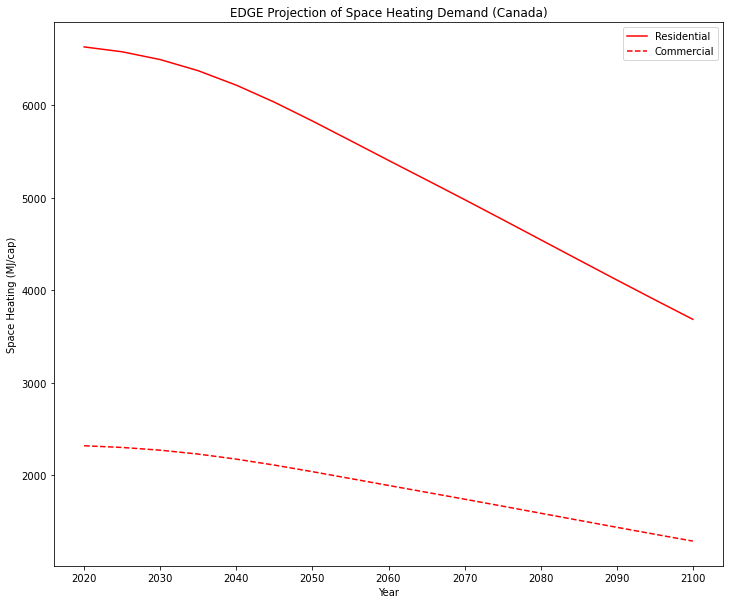

In [50]:
# Space heating plot
fig, ax = plt.subplots(figsize = (12, 10))
ax.plot(PROJ_YEARS,
        res_sh['value'],
        color = 'red',
        label = 'Residential')
ax.plot(PROJ_YEARS,
        com_sh['value'],
        color = 'red',
        ls = '--',
        label = 'Commercial')
ax.legend()
ax.set(title = 'EDGE Projection of Space Heating Demand (Canada)',
       xlabel = 'Year',
       ylabel = 'Space Heating (MJ/cap)');

In [68]:
# Formulas from how_much pp. 517
cmax = 1-(0.949*np.exp(-0.00187*cdd_projection))

In [74]:
# Formula same as above, parameters from SI4
SC = lambda floorspace, u, cm, cdd, I : floorspace*u*cm*cdd*(0.16/(1 + np.exp((20950 - I)/3774)))

res_sc = pd.DataFrame({'year': PROJ_YEARS,
                              'value': np.zeros(len(PROJ_YEARS)),
                              'unit': 'MJ/cap'})

res_sc.set_index('year', inplace = True)

com_sc = pd.DataFrame({'year': PROJ_YEARS,
                              'value': np.zeros(len(PROJ_YEARS)),
                              'unit': 'MJ/cap'})

com_sc.set_index('year', inplace = True)

for year in PROJ_YEARS:
    res_sc.loc[year] = pd.Series({'value': SC(res_floor_demands.loc[year].value, u_values[year], cmax[year], cdd_projection[year], income_proj.loc[year].value),
                                  'unit': 'MJ/cap'},
                                  name = year)
    com_sc.loc[year] = pd.Series({'value': SC(com_floor_demands.loc[year].value, u_values[year], cmax[year], cdd_projection[year], income_proj.loc[year].value),
                                  'unit': 'MJ/cap'},
                                  name = year)

In [ ]:
# Space cooling plot
fig, ax = plt.subplots()
ax.plot(PROJ_YEARS,
        res_sc['value'],
        color = 'blue',
        label = 'Residential')
ax.plot(PROJ_YEARS,
        com_sc['value'],
        color = 'blue',
        ls = '--',
        label = 'Commercial')
ax.legend()

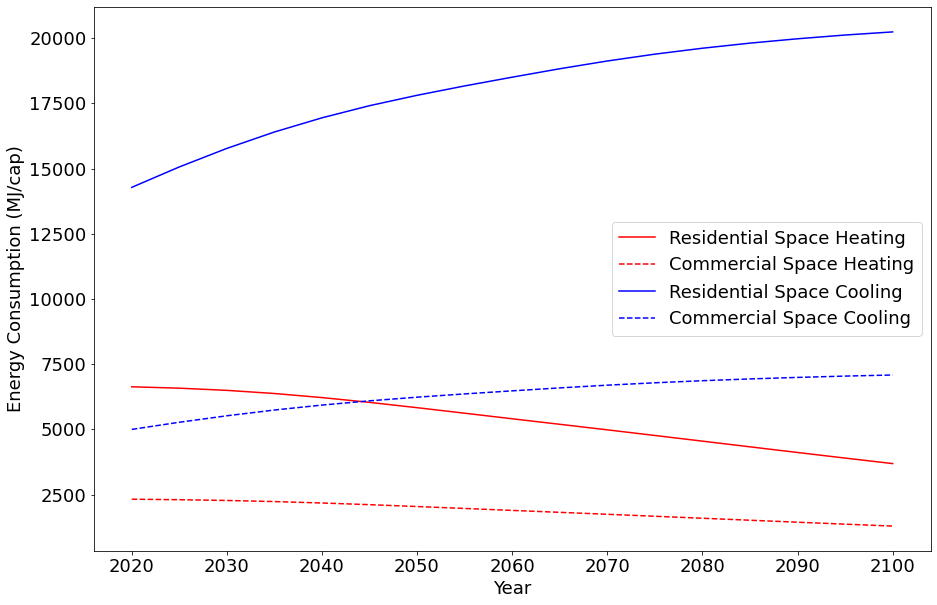

In [150]:
# Space cooling/heating plot
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(PROJ_YEARS,
        res_sh['value'],
        color = 'red',
        label = 'Residential Space Heating')
ax.plot(PROJ_YEARS,
        com_sh['value'],
        color = 'red',
        ls = '--',
        label = 'Commercial Space Heating')
ax.plot(PROJ_YEARS,
        res_sc['value'],
        color = 'blue',
        label = 'Residential Space Cooling')
ax.plot(PROJ_YEARS,
        com_sc['value'],
        color = 'blue',
        ls = '--',
        label = 'Commercial Space Cooling')
ax.legend()
ax.set(xlabel = 'Year',
       ylabel = 'Energy Consumption (MJ/cap)');

In [157]:
fig.savefig(PLOTS / 'heating_cooling.png')

# Appliances and Lighting

In [95]:
# Function from pp. 518, parameters from SI4 (multiplied by 1000000 to convert from TJ to MJ)
appliances = 1e6*np.exp(-7 + 0.3*np.log(income_proj['value']) + (-196/np.sqrt(income_proj['value'])))
appliances = appliances.loc[2020:]

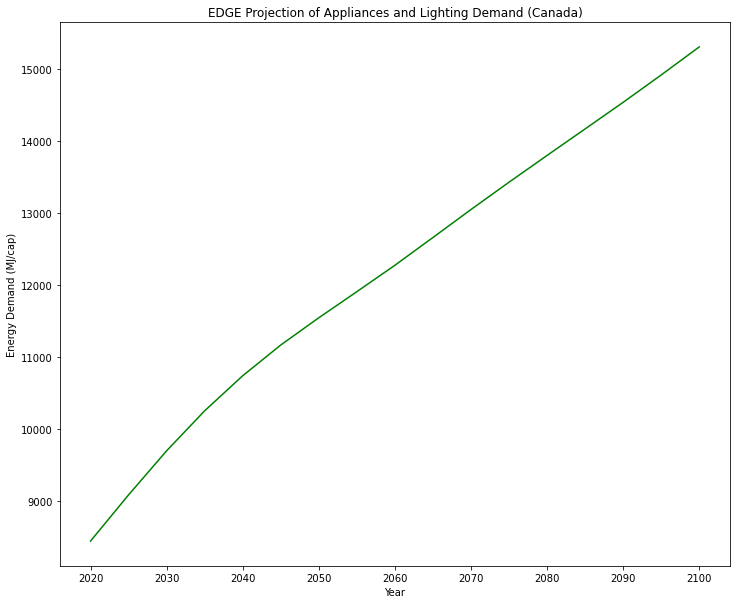

In [101]:
fig, ax = plt.subplots(figsize = (12, 10))
ax.plot(PROJ_YEARS,
        appliances,
        color = 'green')
ax.set(title = 'EDGE Projection of Appliances and Lighting Demand (Canada)',
       xlabel = 'Year',
       ylabel = 'Energy Demand (MJ/cap)');

# Water heating

In [108]:
# Table SI4/5
phi_1 = pd.Series(np.linspace(8.19, 8.19*0.6, num = len(PROJ_YEARS)),
                  index = PROJ_YEARS)

# Function from pp. 518, parameters from SI4,
# multiplied by 1000 to convert from GJ to MJ
water_heating = 1e3*phi_1/(1 + np.exp((24258 - income_proj['value'])/8622))
water_heating = water_heating.loc[2020:]

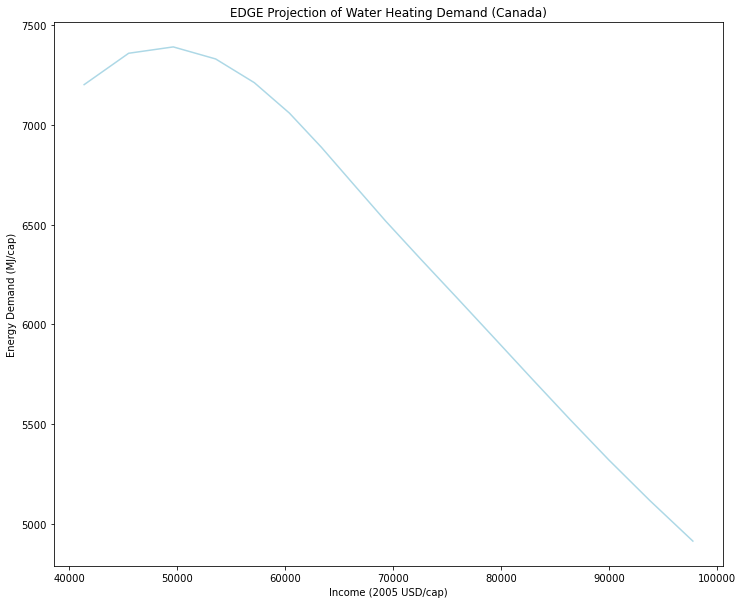

In [125]:
fig, ax = plt.subplots(figsize = (12, 10))
ax.plot(income_proj.loc[2020:]['value'],
        water_heating,
        color = 'lightblue')
ax.set(title = 'EDGE Projection of Water Heating Demand (Canada)',
       xlabel = 'Income (2005 USD/cap)',
       ylabel = 'Energy Demand (MJ/cap)');

# Cooking

In [115]:
# See section 2.3.4 of how_much
cooking = pd.Series([1.8]*len(PROJ_YEARS),
                    index = PROJ_YEARS)*1e3

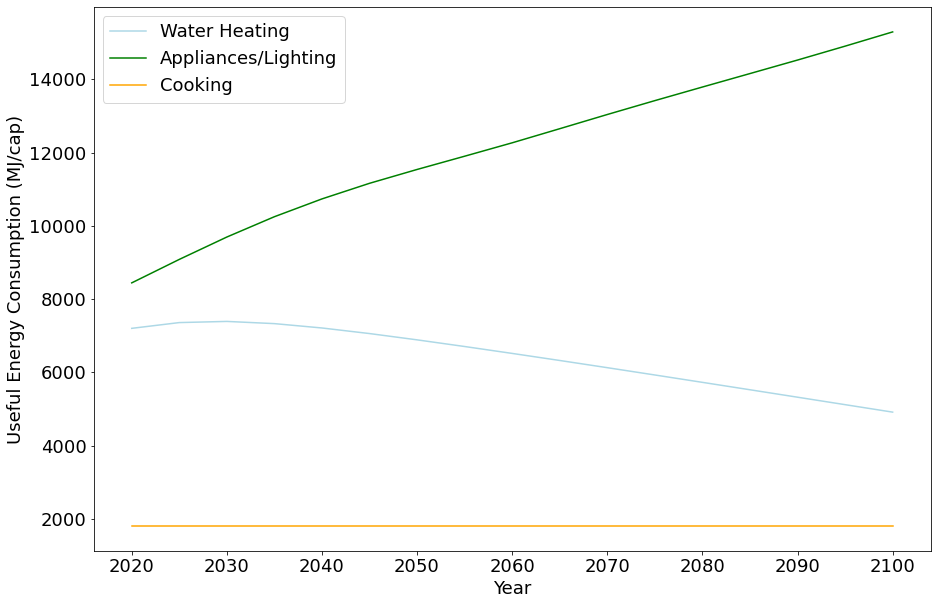

In [162]:
# Plot of appliances, water heating and cooking
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(PROJ_YEARS,
        water_heating,
        color = 'lightblue',
        label = 'Water Heating')
ax.plot(PROJ_YEARS,
        appliances,
        color = 'green',
        label = 'Appliances/Lighting')
ax.plot(PROJ_YEARS,
        cooking,
        color = 'orange',
        label = 'Cooking')
ax.legend()
ax.set(xlabel = 'Year',
       ylabel = 'Useful Energy Consumption (MJ/cap)');

In [163]:
fig.savefig(PLOTS / 'water_appliances_cooking.png')

## Plot of all demands

In [119]:
total = water_heating + appliances + cooking + res_sc['value'] + com_sc['value'] + res_sh['value'] + com_sh['value']

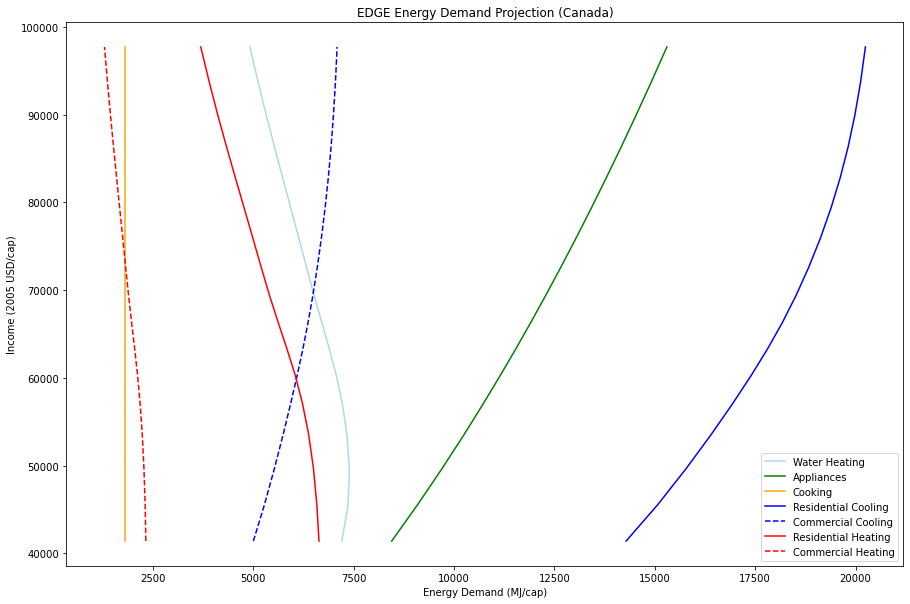

In [128]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(water_heating,
        income_proj.loc[2020:]['value'],
        color = 'lightblue',
        label = 'Water Heating')
ax.plot(appliances,
        income_proj.loc[2020:]['value'],
        color = 'green',
        label = 'Appliances')
ax.plot(cooking,
        income_proj.loc[2020:]['value'],
        color = 'orange',
        label = 'Cooking')
ax.plot(res_sc['value'],
        income_proj.loc[2020:]['value'],
        color = 'blue',
        label = 'Residential Cooling')
ax.plot(com_sc['value'],
        income_proj.loc[2020:]['value'],
        color = 'blue',
        ls = '--',
        label = 'Commercial Cooling')
ax.plot(res_sh['value'],
        income_proj.loc[2020:]['value'],
        color = 'red',
        label = 'Residential Heating')
ax.plot(com_sh['value'],
        income_proj.loc[2020:]['value'],
        color = 'red',
        ls = '--',
        label = 'Commercial Heating')
# ax.plot(total,
#         income_proj.loc[2020:]['value'],
#         color = 'black',
#         label = 'Total Building Usage')
ax.legend()
ax.set(title = 'EDGE Energy Demand Projection (Canada)',
       xlabel = 'Energy Demand (MJ/cap)',
       ylabel = 'Income (2005 USD/cap)');

## Main figure of interest

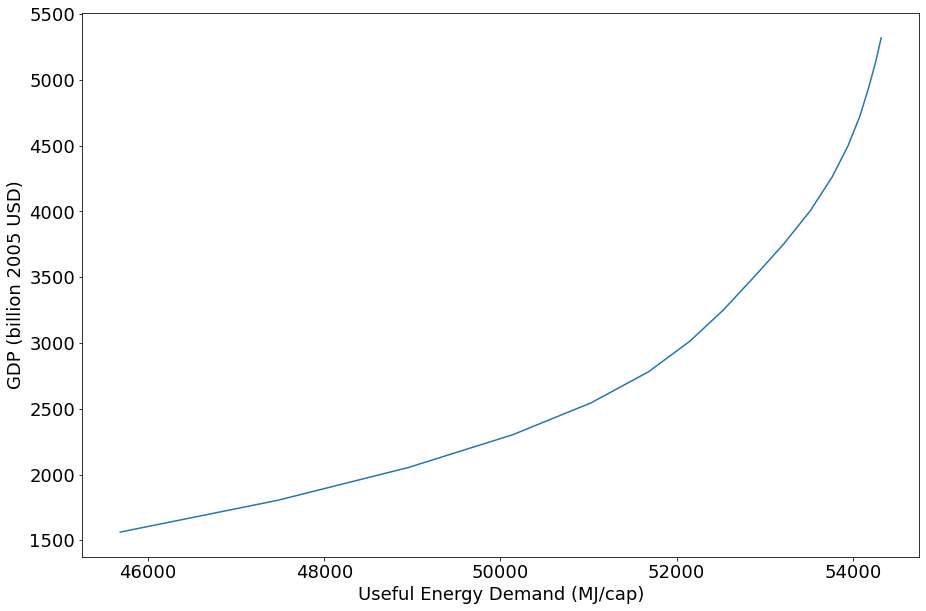

In [169]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(total,
        gdp_proj.loc[2020:]['value'])
ax.set(xlabel = 'Useful Energy Demand (MJ/cap)',
       ylabel = 'GDP (billion 2005 USD)');

In [171]:
fig.savefig(PLOTS / 'edge_uec_vs_gdp')

In [ ]:
plt.figure(figsize = (20,20))
plt.rc('font', size = 25)
plt.plot(gdp_projection, useful_energy)
ax = plt.gca()
plt.scatter(gdp_projection, useful_energy)
for i, label in enumerate(proj_years):
    plt.annotate(label, (gdp_projection[i], useful_energy[i]))
plt.ylabel('Useful energy (MJ/cap)')
plt.xlabel('GDP (billion 2005 USD)')
plt.title('EDGE useful energy demand (Canada)')
plt.savefig('edge_useful.jpg')
plt.show()

# Final to Useful Conversion

In [ ]:
# Conversion efficiencies
elec_conv = 


In [ ]:
sh_wh_carriers = {'Electricity': 0.4, 'Other Grids': 0.5, 'Liquids/Modern Biomass': 0.1}
sc_carriers = {'Electricity': 0.9, 'Other Grids': 0.1}
app_carriers = {'Electricity': 1}

FE = lambda ue, eff, share : (ue/np.sum(eff*share))

FE_sh = np.zeros(len(proj_years))

# for index in range(0, len(proj_years)):
#     FE_sh[index] = FE(space_heating
